In [1]:
import numpy as np
import itertools
import multiprocessing
import pickle
%matplotlib inline
from matplotlib import pyplot as plt

List of parameters

In [2]:
def detailed_sparse_setting():
    # SMALL setting experiments
    setting_name = 'detailed_sparse'
    common = {'v_n': 2, 'v_k': 2, 'v_seed': 43, 'do_transform': True, 'time_limit': 20,
              'num_iterations': 2000, 'log_interval': 25, 'num_eval_episodes': 10, 'eval_interval': 10,
             'alpha': 1.0, 'sparsity': 0.5, 'l2_decoder_coeff': 1e-3, 'collect_episodes_per_iteration': 5,
             'l1coeff': 1e-4, 'learning_rate': 1e-3}
    params = {
        'model_train_epochs': [4, 5],
        'curiosity_interval': [4, 5]
    }
    return setting_name, common, params

Showing the number of total runs

In [3]:
setting_name, common, params = detailed_sparse_setting()

In [4]:
np.prod([len(y) for x, y in params.items()])

4

Creating a list of all runs from a dictionary of parameters

In [5]:
all_params = list(itertools.product(*[[(x, z) for z in y] for x, y in params.items()]))

In [6]:
len(all_params)

4

In [7]:
all_params = [dict(t) for t in all_params]

In [8]:
all_params

[{'model_train_epochs': 4, 'curiosity_interval': 4},
 {'model_train_epochs': 4, 'curiosity_interval': 5},
 {'model_train_epochs': 5, 'curiosity_interval': 4},
 {'model_train_epochs': 5, 'curiosity_interval': 5}]

In [9]:
i = 0
setting_name = "temp"
param = all_params[i]
to_run = {x: y for x, y in param.items()}
to_run["name"] = "output/%s%010d" % (setting_name, i)
to_run.update(common)
to_run['num_iterations'] = 10000
to_run['seed_rest'] = 42
to_run

{'model_train_epochs': 4,
 'curiosity_interval': 4,
 'name': 'output/temp0000000000',
 'v_n': 2,
 'v_k': 2,
 'v_seed': 43,
 'do_transform': True,
 'time_limit': 20,
 'num_iterations': 10000,
 'log_interval': 25,
 'num_eval_episodes': 10,
 'eval_interval': 10,
 'alpha': 1.0,
 'sparsity': 0.5,
 'l2_decoder_coeff': 0.001,
 'collect_episodes_per_iteration': 5,
 'l1coeff': 0.0001,
 'learning_rate': 0.001,
 'seed_rest': 42}

Instructions for updating:
Please use `layer.add_weight` method instead.
1000/1000 [==============================] - 0s 81us/sample - loss: 0.0155


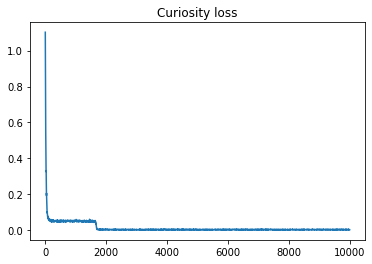

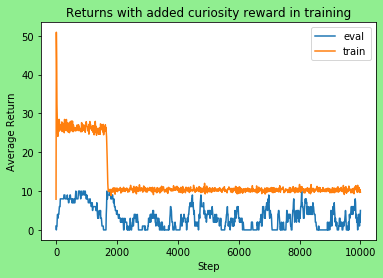

In [10]:
from exp_poc import experiment
experiment(**to_run)

In [11]:
def quality(weights):
    """Compute how well the weights correspond to the simple dynamics that we know.
    
    Always non-positive. Best value: 0
    """
    F, (A, b) = weights
    F = F.T # Keras transposes everything
    A = A.T
    A_sub2x2 = A[:,:2]
    quality_loss = np.linalg.norm((A_sub2x2 - np.eye(2)).flatten(), ord=1)
    return -quality_loss
print(quality(weights[-1]))

NameError: name 'weights' is not defined

In [21]:
# https://github.com/sergeivolodin/OptMLProject/blob/master/create_analyze_runs_helpers.py

def shorten_name(n):
    """ Shorten aba_caba to a_c """
    return '_'.join([x[:3] if len(x) else '' for x in n.split('_')])

def shorten_dict(d, filename = False):
    """ Shorten dictionary into a string """
    if filename:
        return '_'.join([shorten_name(x) + '-' + str(y) for x, y in d.items()])
    if len(d) == 1:
        return list(d.values())[0]
    return ', '.join([shorten_name(x) + ': ' + str(y) for x, y in d.items()])

In [1]:
def process_plot_run(run_id):
    run_params = all_params[run_id]
    prefix = "output/%s%010d" % (setting_name, run_id)
    history = pickle.load(open(prefix + ".history.pkl", "rb"))
    weights = pickle.load(open(prefix + ".weights.pkl", "rb"))
    curiosity_loss, eval_returns, train_returns, eval_loss = history

    fig = plt.figure(figsize=(16, 4))
    fig.patch.set_facecolor('lightgreen')
    fig.suptitle('Param id %d: %s' % (run_id, str(shorten_dict(run_params))), fontsize=16)
    plt.subplot(1, 3, 1)

    plt.title("Curiosity loss")
    plt.plot(curiosity_loss, label="Train loss")
    plt.axhline(eval_loss, ls="--", color="blue", label="Final eval loss")
    plt.axhline(0, ls="--", color="green", label="Best")
    plt.legend()
    #plt.show()

    #plt.figure()
    plt.subplot(1, 3, 2)

    plt.title("Average returns")
    plt.plot(eval_returns, label="Eval return (no curiosity)")
    plt.axhline(10, ls="--", color="green", label="Max return (no curiosity)")
    plt.plot(train_returns, label="Train return (with curiosity)")
    plt.legend()
    #plt.show()

    quality_repr = [quality(t) for t in weights]

    plt.subplot(1, 3, 3)
    plt.title("Quality of representation")
    plt.axhline(0, ls="--", color="green", label="Best quality")
    plt.plot(quality_repr, label="Training quality")
    plt.legend()
    plt.show()

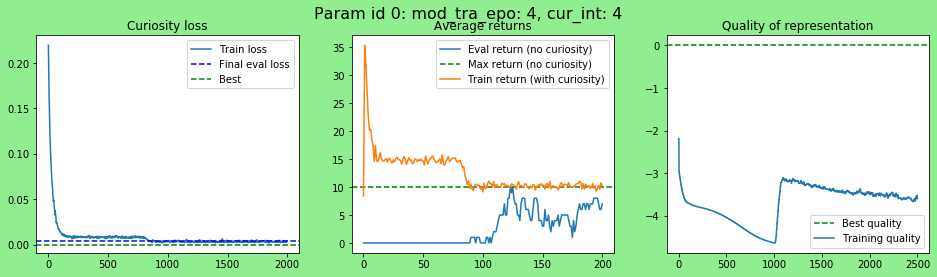

In [24]:
selected_idx = 0
prefix = "output/%s%010d" % (setting_name, selected_idx)
weights = pickle.load(open(prefix + ".weights.pkl", "rb"))
process_plot_run(selected_idx)

In [26]:
F, (A, b) = weights[selected_idx]
F = F.T # Keras transposes everything
A = A.T
A_sub2x2 = A[:,:2]
A_sub2x2

array([[0.25339055, 0.03676939],
       [0.9880707 , 0.5841136 ]], dtype=float32)